In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [52]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

In [29]:
# Hyperparameters
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

In [30]:
# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [31]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [32]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### ViT components

In [33]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x)  # (B, E, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        return x

In [34]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x


In [35]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

In [36]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.norm(x)
        cls_token = x[:, 0]
        return self.head(cls_token)


In [37]:
# Instantiate model
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)

In [38]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [39]:
# Training loop
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)


In [40]:
train(model, train_loader, optimizer, criterion)

(1.7234123652648925, 0.3761)

In [41]:
# Evaluation loop
def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(1) == y).sum().item()
    return correct / len(loader.dataset)



In [42]:
# Training
train_accuracies, test_accuracies = [], []
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_acc = evaluate(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1/10, Train Loss: 1.3886, Train Acc: 0.5014, Test Acc: 0.5337
Epoch 2/10, Train Loss: 1.2500, Train Acc: 0.5529, Test Acc: 0.5597
Epoch 3/10, Train Loss: 1.1445, Train Acc: 0.5921, Test Acc: 0.5847
Epoch 4/10, Train Loss: 1.0560, Train Acc: 0.6253, Test Acc: 0.6039
Epoch 5/10, Train Loss: 0.9835, Train Acc: 0.6497, Test Acc: 0.6085
Epoch 6/10, Train Loss: 0.9080, Train Acc: 0.6766, Test Acc: 0.6133
Epoch 7/10, Train Loss: 0.8407, Train Acc: 0.7004, Test Acc: 0.6202
Epoch 8/10, Train Loss: 0.7673, Train Acc: 0.7301, Test Acc: 0.6217
Epoch 9/10, Train Loss: 0.6990, Train Acc: 0.7512, Test Acc: 0.6371
Epoch 10/10, Train Loss: 0.6302, Train Acc: 0.7746, Test Acc: 0.6263


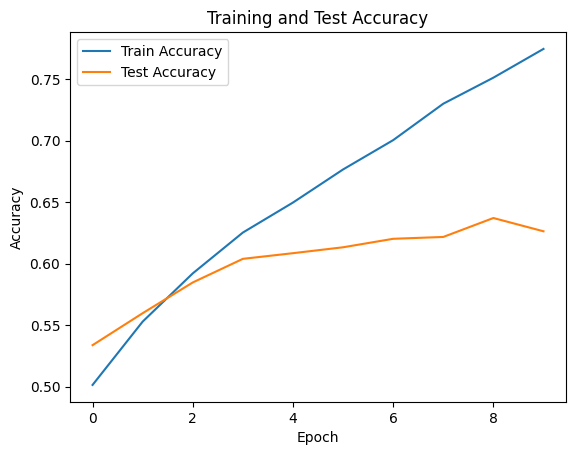

In [43]:
# Plot accuracy
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy')
plt.show()

In [46]:
import random
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            color = classes[true_label] == classes[predicted.item()]
            if color:
                c = "g"
            else:
                c = "r"
            axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=c)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

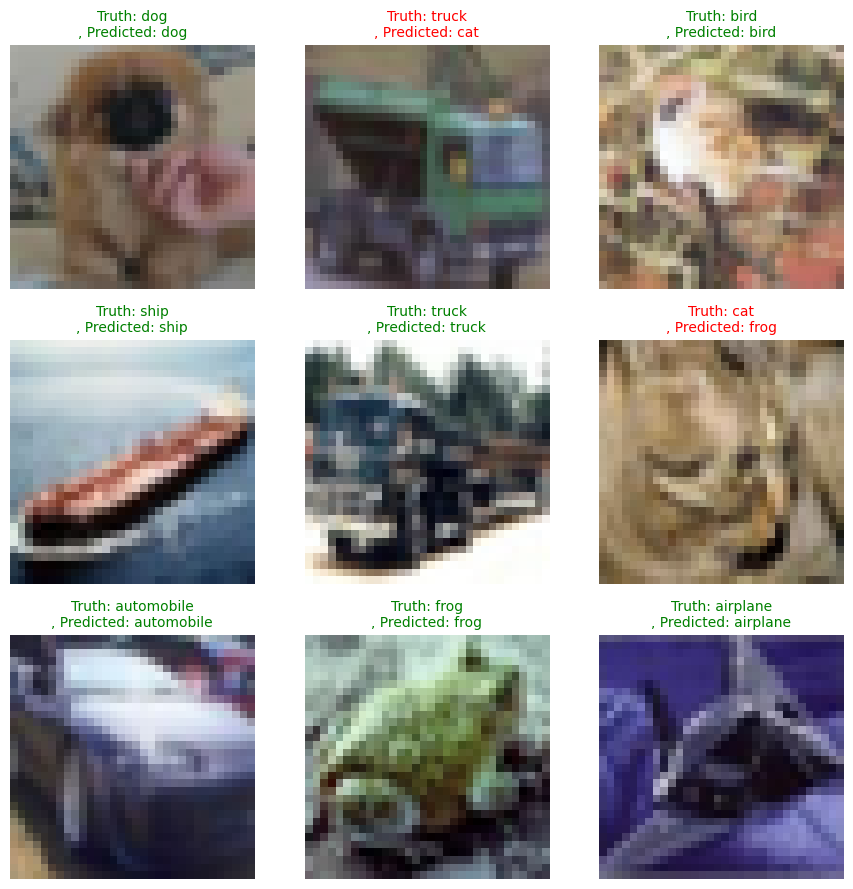

In [50]:
predict_and_plot_grid(model, test_dataset, classes=train_dataset.classes, grid_size=3)

In [54]:
from pathlib import Path

directory = Path("models")
directory.mkdir(parents=True,
                exist_ok=True)

In [55]:
model_name = "Vision_Transformer_On_CIFAR_10_From_Scratch.pth"

In [56]:
model_path = directory / model_name

In [57]:
torch.save(model.state_dict(),
           f=model_path)

In [61]:
# Load the model again
loaded_model = VisionTransformer( IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)

In [62]:
loaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

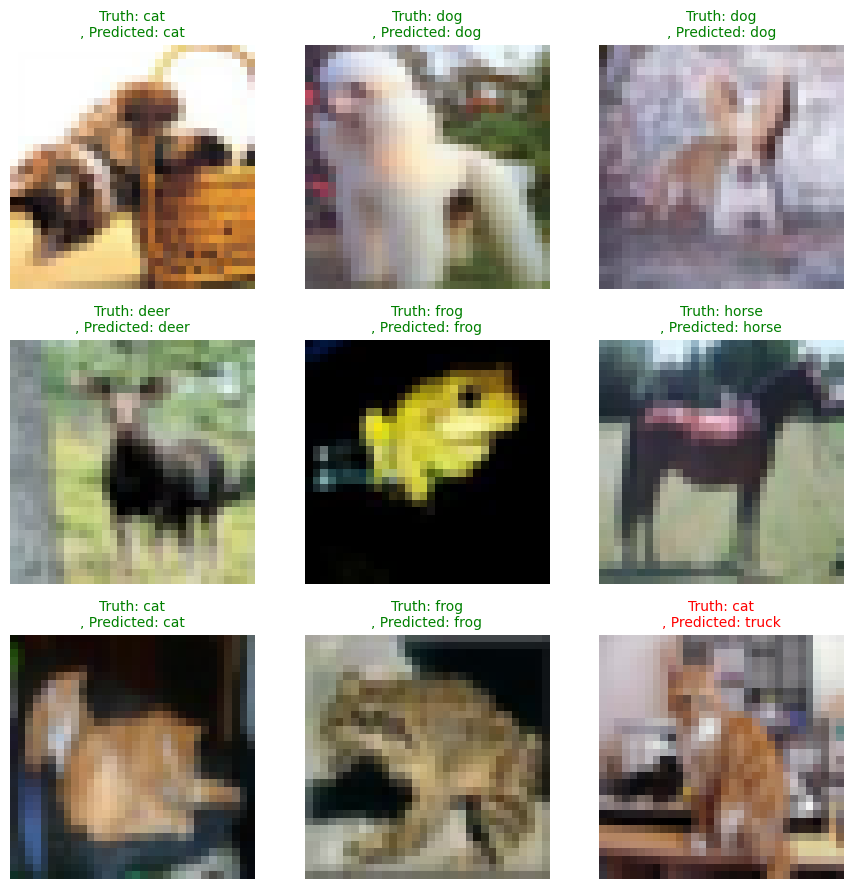

In [64]:
predict_and_plot_grid(loaded_model, test_dataset, classes=train_dataset.classes, grid_size=3)